# Attention : 
# Faire "File -> Save a copy in Drive" avant de commencer à modifier le notebook, sinon vos modifications ne seront pas sauvegardées.


In [17]:
!wget http://webia.lip6.fr/~dancette/deep-learning/assets/TP3-4/TP3-4.zip
!unzip -j TP3-4.zip

--2020-12-12 04:47:15--  http://webia.lip6.fr/~dancette/deep-learning/assets/TP3-4/TP3-4.zip
Resolving webia.lip6.fr (webia.lip6.fr)... 132.227.201.33
Connecting to webia.lip6.fr (webia.lip6.fr)|132.227.201.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13421167 (13M) [application/zip]
Saving to: ‘TP3-4.zip.1’

TP3-4.zip.1         100%[===================>]  12.80M  8.45MB/s    in 1.5s    

2020-12-12 04:47:17 (8.45 MB/s) - ‘TP3-4.zip.1’ saved [13421167/13421167]

Archive:  TP3-4.zip
replace tme5.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: tme5.py                 
  inflating: mnist.mat               
  inflating: circles.py              
  inflating: circles.mat             


In [18]:
import math
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%run tme5.py

<Figure size 432x288 with 0 Axes>

# Partie 1 : Forward et Backward manuels

In [19]:
def init_params(nx, nh, ny):
    """
    nx, nh, ny: integers
    out params: dictionnary
    """
    params = {}
    
    # remplir avec les paramètres Wh, Wy, bh, by

    params["Wh"] = torch.normal(mean=0, std=0.3, size=(nh,nx))
                # or torch.randn(nh, nx).normal_(mean=0,std=0.3)
    params["Wy"] = torch.normal(mean=0, std=0.3, size=(ny,nh))
    params["bh"] = torch.normal(mean=0, std=0.3, size=(nh,))
    params["by"] = torch.normal(mean=0, std=0.3, size=(ny,))
    
    return params

In [20]:
def forward(params, X):
    """
    params: dictionnary
    X: (n_batch, dimension)
    """
    bsize = X.size(0)
    nh = params['Wh'].size(0)
    ny = params['Wy'].size(0)
    outputs = {}


    # remplir avec les paramètres X, htilde, h, ytilde, yhat
    
    outputs["X"] = X
    outputs["htilde"] = torch.mm(X,params["Wh"].T) + params["bh"]
    outputs["h"] = torch.tanh(outputs["htilde"])
    outputs["ytilde"] = torch.mm(outputs["h"],params["Wy"].T) + params["by"]
    outputs["yhat"] = torch.exp(outputs["ytilde"]) / torch.sum(torch.exp(outputs["ytilde"]), dim=1, keepdim=True)

    return outputs['yhat'], outputs

In [21]:
def loss_accuracy(Yhat, Y):


    L = 0
    acc = 0

    L = -torch.mean(torch.sum(Y*torch.log(Yhat)))

    _, indsY = torch.max(Y, 1)
    _, indsYhat = torch.max(Yhat, 1)
    acc = (indsY == indsYhat).float().mean()*100

    return L, acc

In [22]:
def backward(params, outputs, Y):
    bsize = Y.shape[0]
    grads = {}

    # remplir avec les paramètres Wy, Wh, by, bh

    # dérivé de L par rapport à ytilde
    grad_L_ytilde = outputs['yhat'] - Y 

    # dérivé de ytilde par rapport à Wh
    grad_ytilde_Wh = outputs['h']
    # dérivé de ytilde par rapport à Bh
    grad_ytilde_bh = 1


    grads["Wy"] = torch.mm(grad_L_ytilde.T, grad_ytilde_Wh)   # dérivé de L par rapport à Wy
    grads["by"] = torch.sum(grad_L_ytilde, dim=0)   # dérivé de L par rapport à by

    # dérivé de y_tilde par rapport à h
    grad_ytilde_h = params['Wy']
    # dérivé de L par rapport à htilde
    grad_h_htilde = torch.mm(grad_L_ytilde,grad_ytilde_h) * (1-torch.pow(grad_ytilde_Wh,2))

    grads["Wh"] = torch.mm(grad_h_htilde, outputs['X'])  # dérivé de L par rapport à Wh
    
    grads["bh"] = torch.sum(grad_h_htilde, dim=0)  # dérivé de L par rapport à bh

    return grads

In [23]:
def sgd(params, grads, eta):
    params["Wh"] = params["Wh"] - eta * grads['Wh']  
    params["Wy"] = params["Wy"] - eta * grads['Wy']  
    params["bh"] = params["bh"] - eta * grads['bh']  
    params["by"] = params["by"] - eta * grads['by']    

    return params

## Algorithme global d'apprentissage (manuel)

In [24]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

params = init_params(nx, nh, ny)

curves = [[],[], [], []]

# epoch
for iteration in range(150):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]


    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # écrire l'algorithme d'apprentissage sur le batch (X,Y)
        # en utilisant les fonctions forward, loss_accuracy, backward, sgd 

        Yhat, outputs = forward(params, X)
        loss, acc = loss_accuracy(Yhat, Y)
        grads = backward(params, outputs, Y) 
        params = sgd(params, grads, eta)

    Yhat_train, _ = forward(params, data.Xtrain)
    Yhat_test, _ = forward(params, data.Xtest)
    Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)
    Ygrid, _ = forward(params, data.Xgrid)  

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    print(title)
    data.plot_data_with_grid(Ygrid, title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Partie 2 : Simplification du backward avec `torch.autograd`



In [25]:
def init_params(nx, nh, ny):
    """
    nx, nh, ny: integers
    out params: dictionnary
    """
    params = {}
    

    # remplir avec les paramètres Wh, Wy, bh, by
    # activer l'autograd sur les poids du réseau
    
    params["Wh"] = torch.normal(mean=0, std=0.3, size=(nh, nx), requires_grad=True)
    params["Wy"] = torch.normal(mean=0, std=0.3, size=(ny, nh), requires_grad=True)
    params["bh"] = torch.normal(mean=0, std=0.3, size=(nh,), requires_grad=True)
    params["by"] = torch.normal(mean=0, std=0.3, size=(ny,), requires_grad=True)
    

    return params

La fonction `forward` est inchangée par rapport à la partie précédente. 

La fonction `backward` n'est plus utilisée grâce à l'autograd. 

In [26]:
def sgd(params, eta):

    # mettre à jour le contenu de params
    # attention à bien utiliser torch.no_grad()
    # et à remettre les accumulateurs de gradients à zéro
    with torch.no_grad():
        for param in params.values():
          param-= eta*param.grad
          param.grad.zero_()


    return params

## Algorithme global d'apprentissage (avec autograd)

In [27]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

params = init_params(nx, nh, ny)

curves = [[],[], [], []]

# epoch
for iteration in range(150):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]


    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]
  
        # écrire l'algorithme d'apprentissage sur le batch (X,Y)
        # en utilisant les fonctions forward, loss_accuracy, sgd 
        # calculer les gradients avec la fonction backward de l'autograd 

        Yhat, outputs = forward(params, X)
        loss, acc = loss_accuracy(Yhat, Y)
        loss.backward()
        params = sgd(params, eta)



    Yhat_train, _ = forward(params, data.Xtrain)
    Yhat_test, _ = forward(params, data.Xtest)
    Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)
    Ygrid, _ = forward(params, data.Xgrid)  

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    print(title)
    # detach() est utilisé pour détacher les predictions du graphes de calcul autograd
    data.plot_data_with_grid(Ygrid.detach(), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Partie 3 : Simplification du forward avec `torch.nn`

`init_params` et `forward` sont supprimés et remplacés par une fonction `init_model` qui déclare l'architecture du modèle et la loss.

In [28]:
def init_model(nx, nh, ny):

    model = torch.nn.Sequential(
        torch.nn.Linear(nx, nh),
        torch.nn.Tanh(),
        torch.nn.Linear(nh, ny),
    )
    # This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class 
    loss = torch.nn.CrossEntropyLoss()

    return model, loss

In [29]:
def loss_accuracy(loss, Yhat, Y):

    # faire appel à la fonction de loss

    L = loss(Yhat, Y)
    _, indsYhat = torch.max(Yhat, 1)
    acc = (Y == indsYhat).float().mean()*100

    return L, acc

In [30]:
def sgd(model, eta):

    # mettre à jour les paramètres de model
    # attention à bien utiliser torch.no_grad()
    # et à remettre les accumulateurs de gradients à zéro
    with torch.no_grad():
        for param in model.parameters():
            param -= eta * param.grad
        model.zero_grad()

    return model

## Algorithme global d'apprentissage (avec autograd et les couches `torch.nn`)

In [31]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

model, loss = init_model(nx, nh, ny)

curves = [[],[], [], []]

# epoch
for iteration in range(150):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]
    Ytrain = torch.argmax(Ytrain, dim=1)

    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch]
  
        # écrire l'algorithme d'apprentissage sur le batch (X,Y)
        # en utilisant les fonctions loss_accuracy, sgd
        # effectuer le forward en faisant un appel au modèle 
        # calculer les gradients avec la fonction backward de l'autograd 

        Yhat = model(X)
        l, acc = loss_accuracy(loss, Yhat, Y)
        l.backward()
        sgd(model, eta)



    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)

    Ytrain = torch.argmax(data.Ytrain, dim=1)
    Ltrain, acctrain = loss_accuracy(loss, Yhat_train, Ytrain)
    Ytest = torch.argmax(data.Ytest, dim=1)
    Ltest, acctest = loss_accuracy(loss, Yhat_test, Ytest)
    Ygrid = model(data.Xgrid)  

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    print(title) 
    data.plot_data_with_grid(torch.nn.Softmax(dim=1)(Ygrid.detach()), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Partie 4 : Simplification de SGD avec `torch.optim`

In [ ]:
def init_model(nx, nh, ny, eta):
  
    model = torch.nn.Sequential(
        torch.nn.Linear(nx, nh),
        torch.nn.Tanh(),
        torch.nn.Linear(nh, ny),
    )
    # This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class 
    loss = torch.nn.CrossEntropyLoss()
    optim = torch.optim.SGD(model.parameters(), lr=eta)

    return model, loss, optim

La fonction `sgd` est supprimée. À la place, on fera un appel à `optim.zero_grad()` avant de faire le backward et à `optim.step()` après le backward. 

## Algorithme global d'apprentissage (avec autograd, les couches `torch.nn` et `torch.optim`)

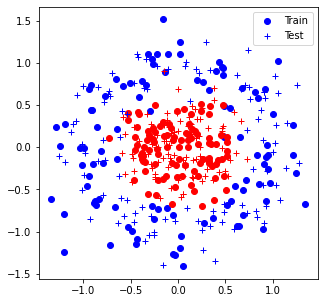

Iter 0: Acc train 63.5% (0.69), acc test 66.0% (0.69)


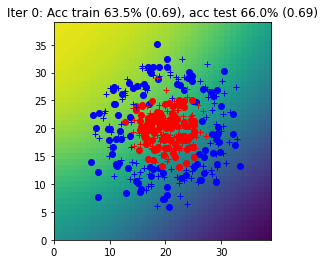

Iter 1: Acc train 62.5% (0.69), acc test 63.5% (0.69)


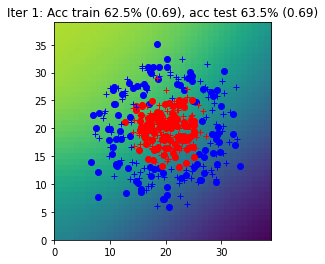

Iter 2: Acc train 60.0% (0.69), acc test 64.0% (0.68)


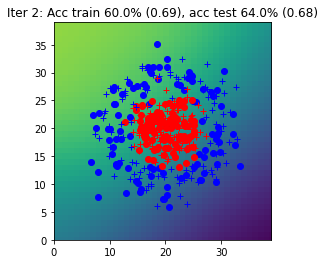

Iter 3: Acc train 57.5% (0.69), acc test 62.5% (0.68)


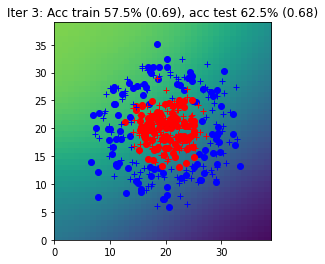

Iter 4: Acc train 56.0% (0.69), acc test 61.5% (0.68)


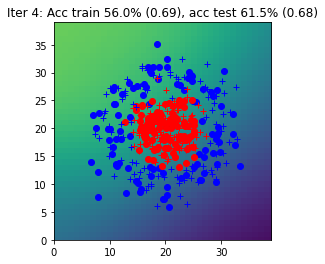

Iter 5: Acc train 56.5% (0.69), acc test 61.5% (0.68)


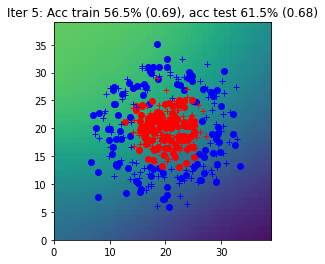

Iter 6: Acc train 56.0% (0.68), acc test 62.0% (0.68)


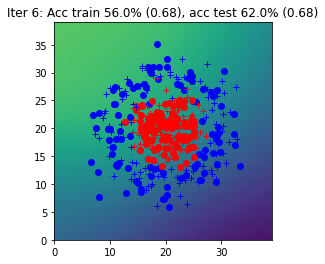

Iter 7: Acc train 58.5% (0.68), acc test 62.5% (0.68)


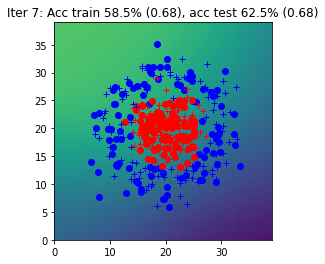

Iter 8: Acc train 57.5% (0.68), acc test 59.0% (0.68)


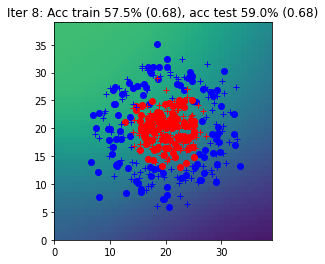

Iter 9: Acc train 58.5% (0.68), acc test 61.5% (0.68)


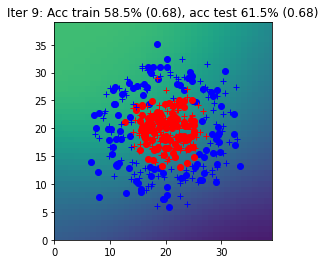

Iter 10: Acc train 58.5% (0.68), acc test 62.0% (0.68)


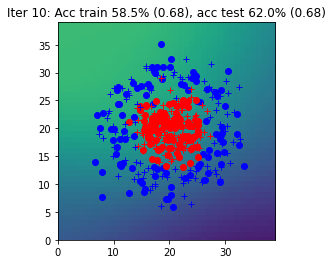

Iter 11: Acc train 58.5% (0.68), acc test 62.0% (0.68)


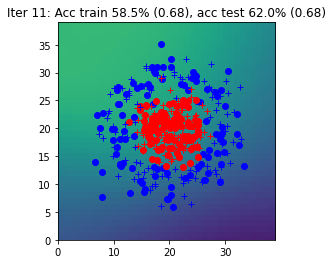

Iter 12: Acc train 59.5% (0.68), acc test 65.0% (0.68)


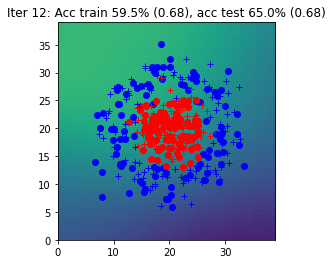

Iter 13: Acc train 62.0% (0.68), acc test 65.5% (0.68)


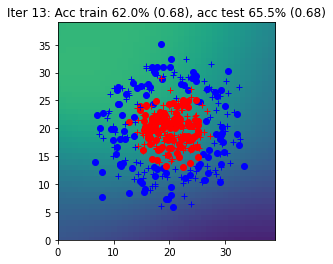

Iter 14: Acc train 63.5% (0.68), acc test 65.0% (0.68)


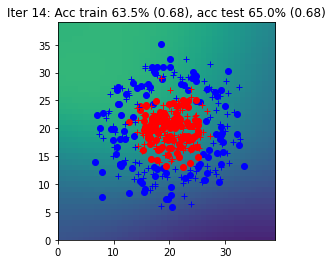

Iter 15: Acc train 63.0% (0.68), acc test 65.5% (0.68)


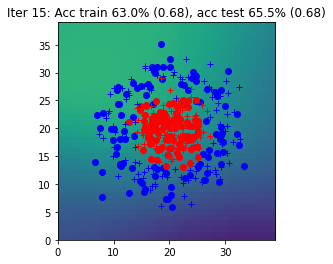

Iter 16: Acc train 62.5% (0.68), acc test 67.0% (0.67)


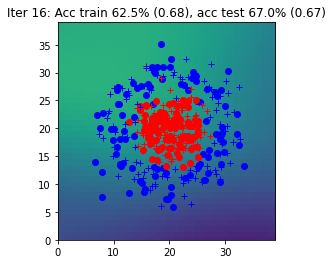

Iter 17: Acc train 62.0% (0.68), acc test 66.5% (0.67)


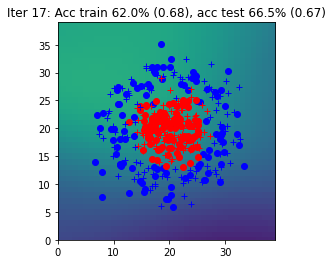

Iter 18: Acc train 64.0% (0.67), acc test 66.5% (0.67)


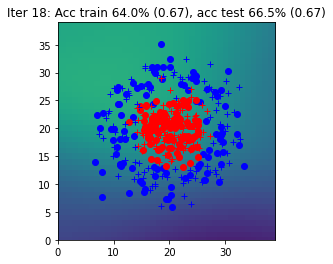

Iter 19: Acc train 68.5% (0.67), acc test 67.0% (0.67)


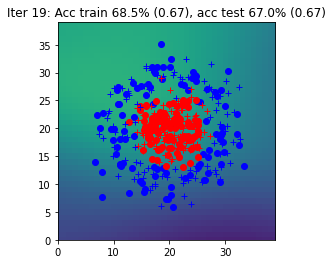

Iter 20: Acc train 64.5% (0.67), acc test 67.5% (0.67)


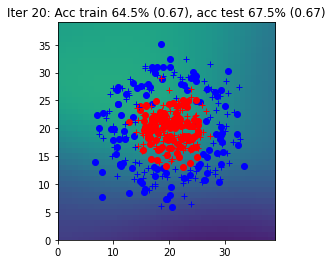

Iter 21: Acc train 69.5% (0.67), acc test 69.0% (0.67)


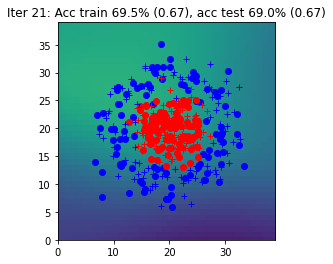

Iter 22: Acc train 69.5% (0.67), acc test 70.0% (0.67)


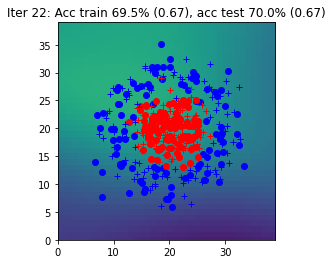

Iter 23: Acc train 69.5% (0.67), acc test 70.0% (0.67)


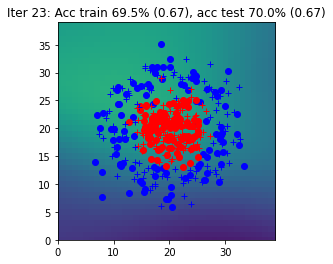

Iter 24: Acc train 70.5% (0.67), acc test 72.5% (0.67)


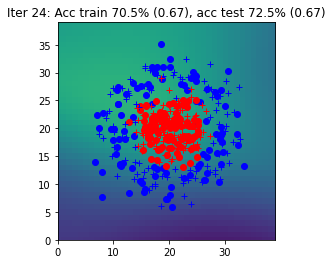

Iter 25: Acc train 70.0% (0.66), acc test 71.5% (0.66)


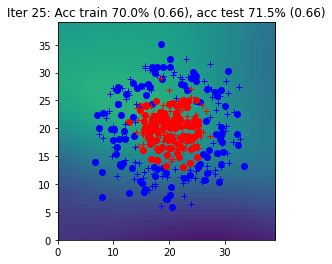

Iter 26: Acc train 71.0% (0.66), acc test 73.5% (0.66)


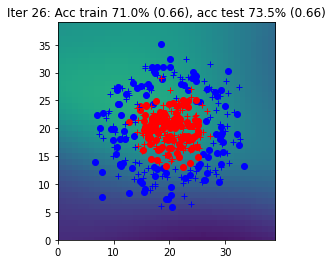

Iter 27: Acc train 70.5% (0.66), acc test 74.0% (0.66)


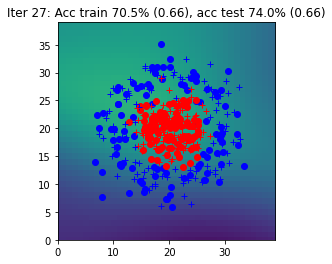

Iter 28: Acc train 71.5% (0.66), acc test 74.0% (0.66)


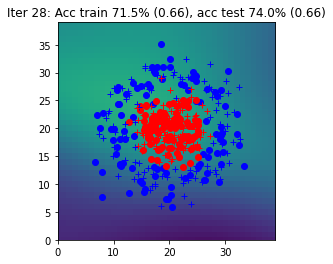

Iter 29: Acc train 70.0% (0.66), acc test 74.0% (0.66)


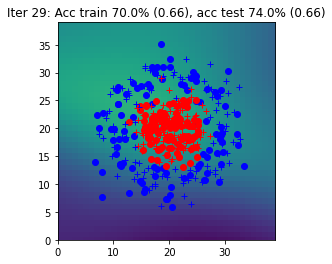

Iter 30: Acc train 70.0% (0.66), acc test 73.0% (0.66)


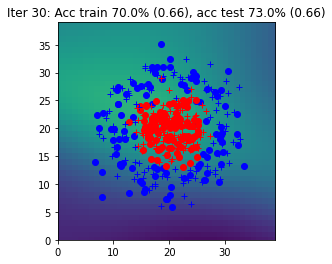

Iter 31: Acc train 70.0% (0.65), acc test 76.5% (0.65)


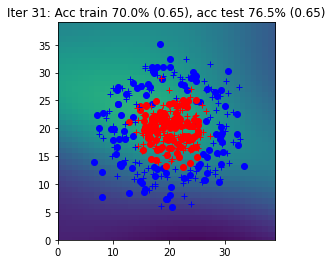

Iter 32: Acc train 69.5% (0.65), acc test 75.5% (0.65)


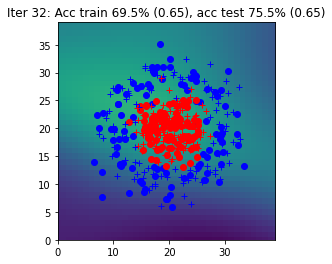

Iter 33: Acc train 72.0% (0.65), acc test 76.5% (0.65)


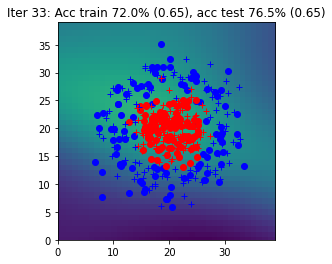

Iter 34: Acc train 73.5% (0.65), acc test 77.5% (0.65)


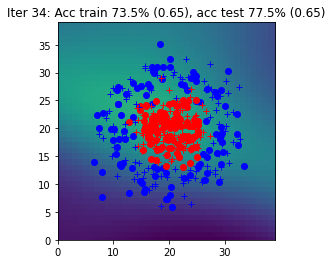

Iter 35: Acc train 73.0% (0.65), acc test 75.5% (0.65)


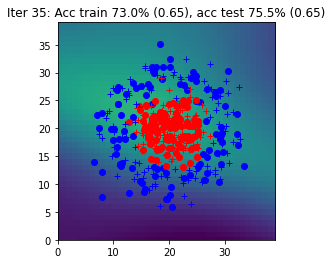

Iter 36: Acc train 72.5% (0.64), acc test 76.0% (0.64)


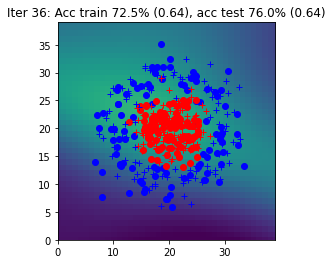

Iter 37: Acc train 75.0% (0.64), acc test 78.0% (0.64)


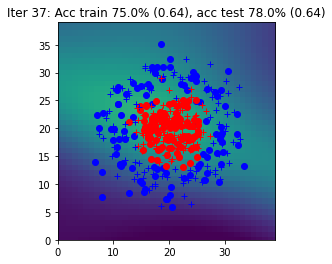

Iter 38: Acc train 73.0% (0.64), acc test 76.0% (0.64)


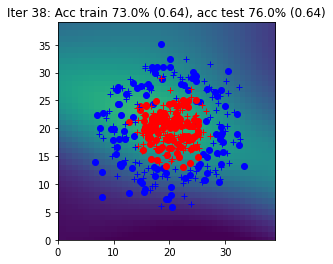

Iter 39: Acc train 73.0% (0.63), acc test 76.0% (0.64)


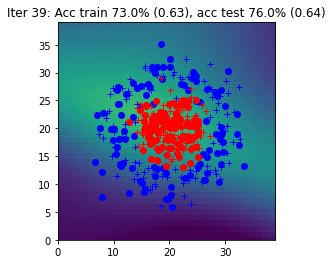

Iter 40: Acc train 73.0% (0.63), acc test 78.0% (0.63)


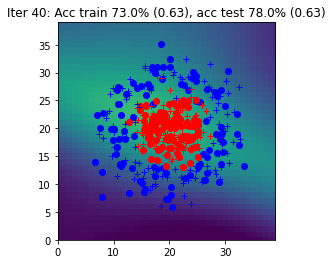

Iter 41: Acc train 73.0% (0.63), acc test 78.5% (0.63)


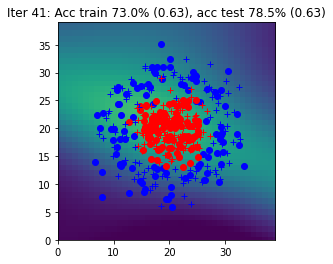

Iter 42: Acc train 73.5% (0.63), acc test 80.0% (0.63)


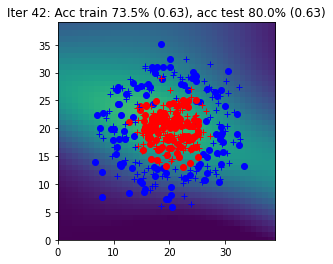

Iter 43: Acc train 76.0% (0.62), acc test 80.5% (0.63)


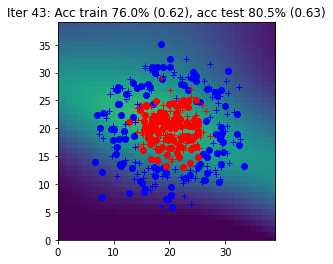

Iter 44: Acc train 75.0% (0.62), acc test 80.5% (0.62)


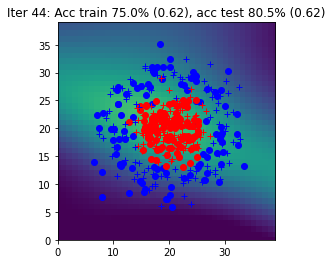

Iter 45: Acc train 75.0% (0.62), acc test 80.5% (0.62)


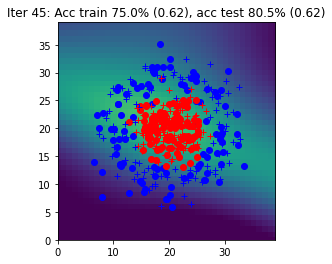

Iter 46: Acc train 75.5% (0.61), acc test 80.0% (0.62)


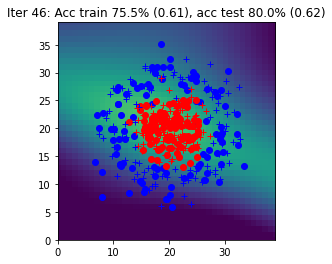

Iter 47: Acc train 76.5% (0.61), acc test 79.5% (0.61)


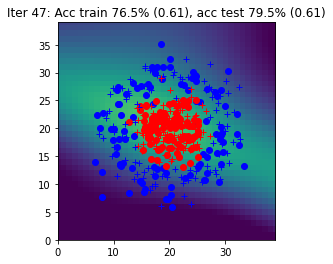

Iter 48: Acc train 76.5% (0.61), acc test 79.5% (0.61)


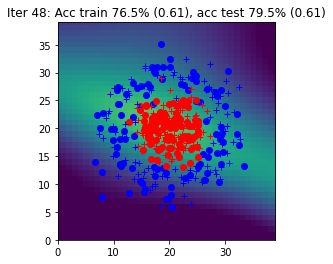

Iter 49: Acc train 75.5% (0.60), acc test 79.5% (0.61)


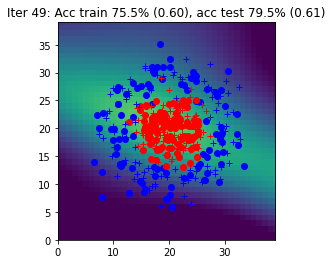

Iter 50: Acc train 75.5% (0.60), acc test 79.0% (0.60)


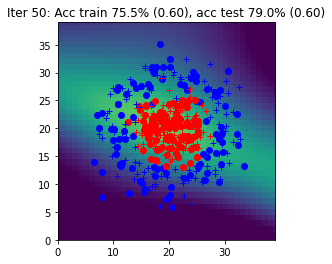

Iter 51: Acc train 77.0% (0.60), acc test 79.0% (0.60)


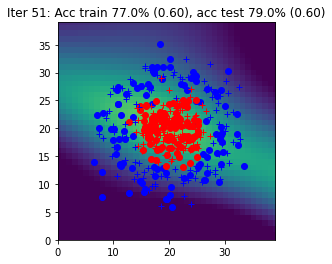

Iter 52: Acc train 77.0% (0.59), acc test 78.5% (0.60)


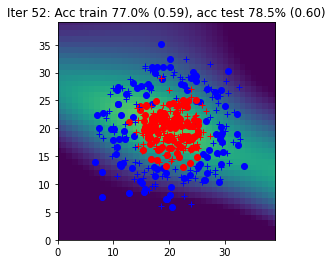

Iter 53: Acc train 76.5% (0.59), acc test 78.0% (0.59)


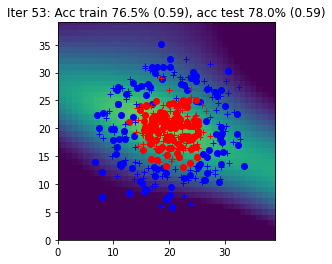

Iter 54: Acc train 77.0% (0.59), acc test 78.0% (0.59)


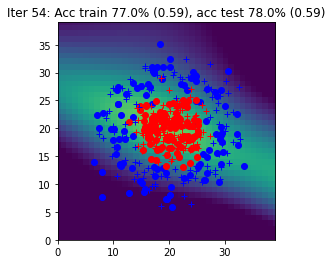

Iter 55: Acc train 77.0% (0.58), acc test 77.5% (0.58)


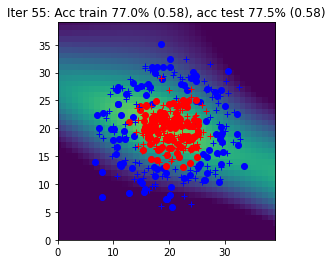

Iter 56: Acc train 76.5% (0.58), acc test 77.5% (0.58)


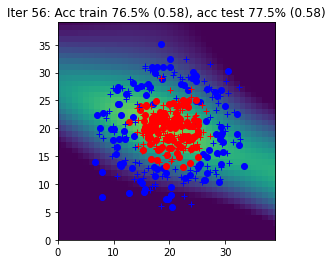

Iter 57: Acc train 79.0% (0.57), acc test 78.5% (0.58)


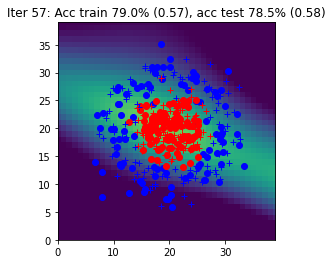

Iter 58: Acc train 77.5% (0.57), acc test 77.5% (0.57)


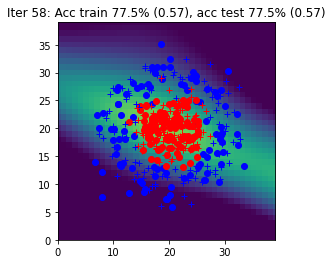

Iter 59: Acc train 77.0% (0.57), acc test 77.5% (0.57)


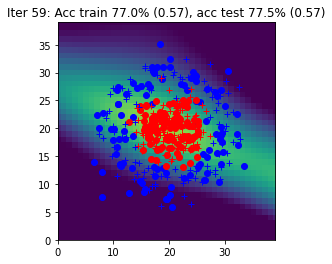

Iter 60: Acc train 77.0% (0.56), acc test 77.0% (0.57)


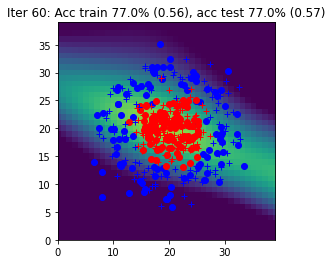

Iter 61: Acc train 79.0% (0.56), acc test 79.0% (0.56)


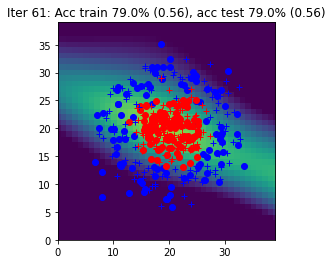

Iter 62: Acc train 79.0% (0.55), acc test 78.5% (0.56)


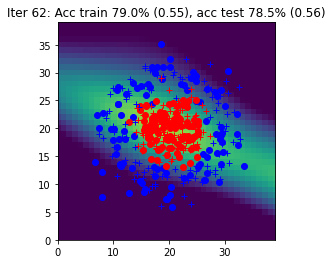

Iter 63: Acc train 78.5% (0.55), acc test 78.0% (0.55)


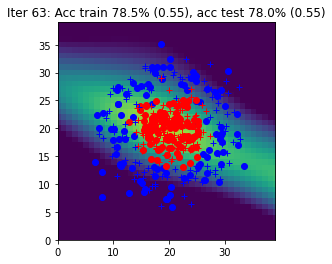

Iter 64: Acc train 79.0% (0.55), acc test 78.0% (0.55)


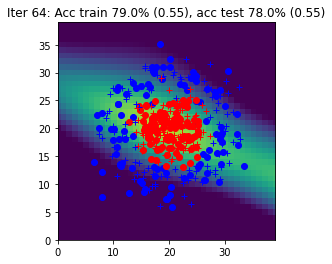

Iter 65: Acc train 78.5% (0.54), acc test 78.0% (0.55)


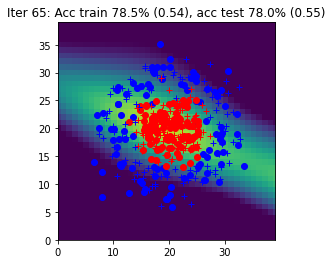

Iter 66: Acc train 78.0% (0.54), acc test 78.0% (0.54)


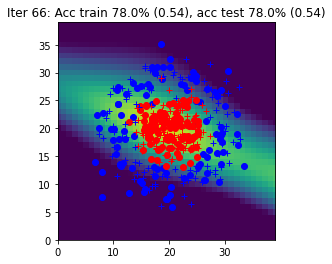

Iter 67: Acc train 79.0% (0.53), acc test 79.0% (0.54)


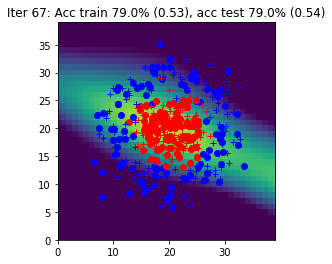

Iter 68: Acc train 79.5% (0.53), acc test 79.0% (0.53)


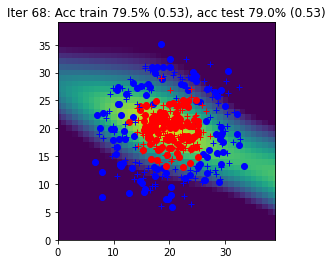

Iter 69: Acc train 79.0% (0.53), acc test 78.5% (0.53)


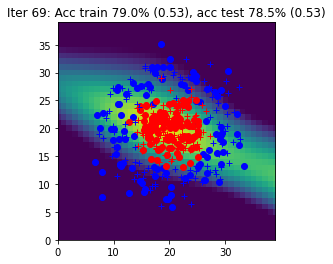

Iter 70: Acc train 79.0% (0.52), acc test 80.5% (0.53)


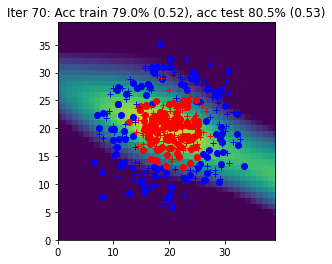

Iter 71: Acc train 79.0% (0.52), acc test 79.0% (0.52)


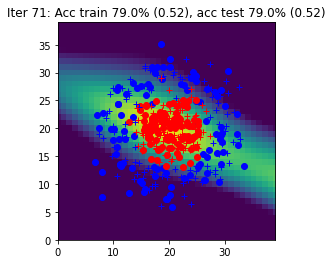

Iter 72: Acc train 79.0% (0.51), acc test 80.0% (0.52)


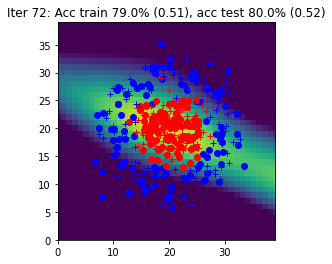

Iter 73: Acc train 79.0% (0.51), acc test 80.0% (0.52)


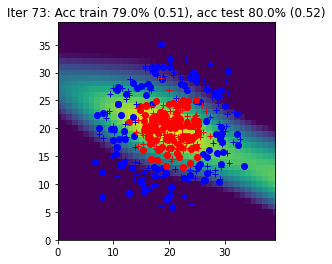

Iter 74: Acc train 79.0% (0.51), acc test 80.5% (0.51)


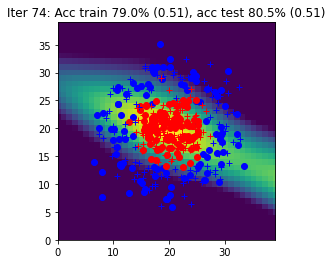

Iter 75: Acc train 79.0% (0.50), acc test 80.5% (0.51)


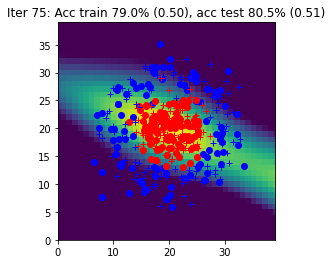

Iter 76: Acc train 81.0% (0.50), acc test 82.0% (0.50)


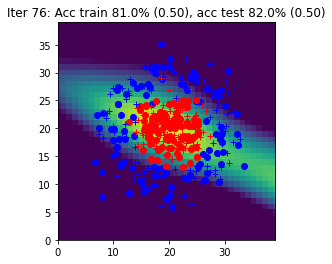

Iter 77: Acc train 80.0% (0.50), acc test 81.5% (0.50)


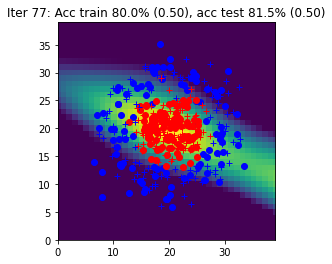

Iter 78: Acc train 79.0% (0.49), acc test 81.5% (0.50)


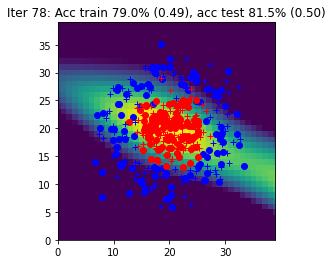

Iter 79: Acc train 79.5% (0.49), acc test 81.0% (0.49)


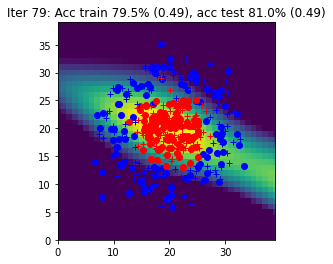

Iter 80: Acc train 79.5% (0.48), acc test 80.5% (0.49)


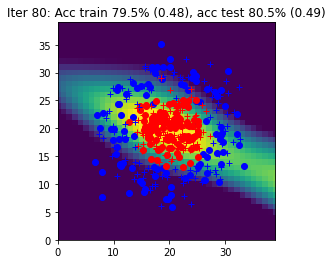

Iter 81: Acc train 79.5% (0.48), acc test 82.5% (0.48)


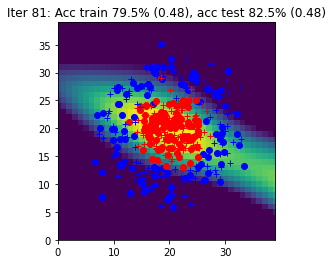

Iter 82: Acc train 80.0% (0.48), acc test 82.0% (0.48)


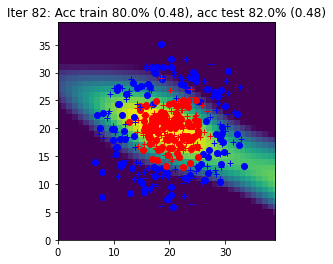

Iter 83: Acc train 79.5% (0.47), acc test 83.0% (0.48)


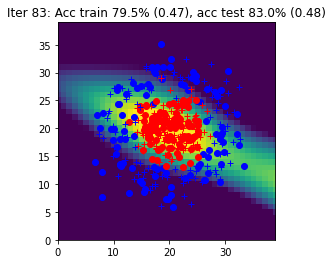

Iter 84: Acc train 79.5% (0.47), acc test 83.0% (0.47)


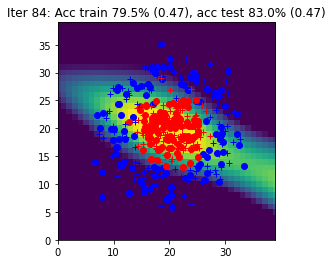

Iter 85: Acc train 82.0% (0.46), acc test 82.5% (0.47)


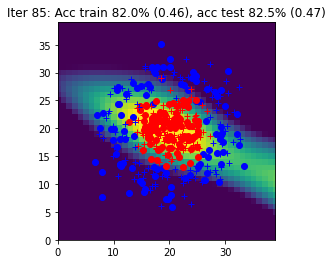

Iter 86: Acc train 82.5% (0.46), acc test 83.0% (0.47)


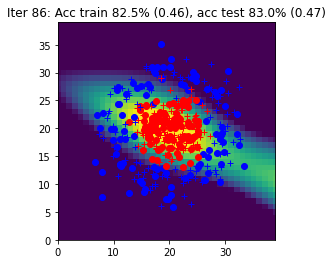

Iter 87: Acc train 82.0% (0.46), acc test 83.0% (0.46)


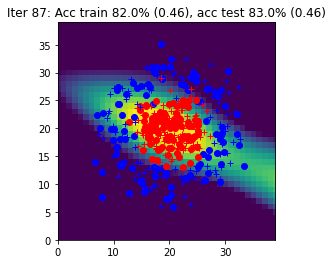

Iter 88: Acc train 82.0% (0.45), acc test 82.5% (0.46)


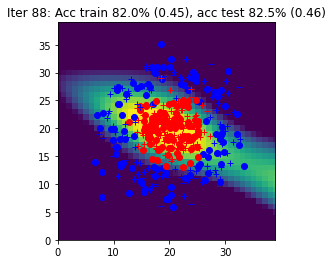

Iter 89: Acc train 82.5% (0.45), acc test 83.5% (0.45)


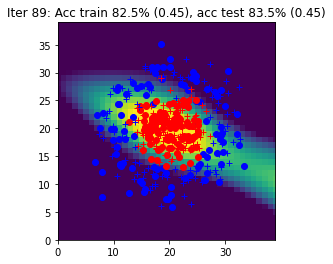

Iter 90: Acc train 82.5% (0.44), acc test 84.0% (0.45)


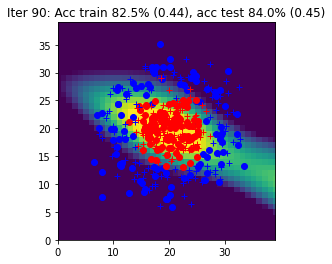

Iter 91: Acc train 83.5% (0.44), acc test 84.5% (0.44)


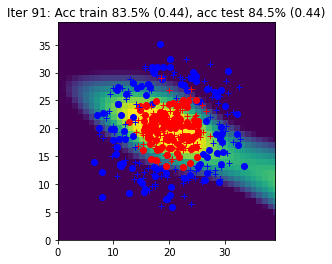

Iter 92: Acc train 84.0% (0.43), acc test 84.5% (0.44)


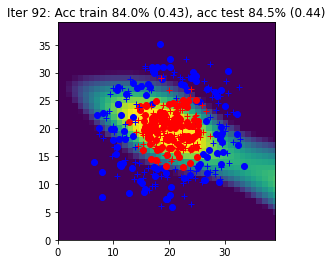

Iter 93: Acc train 84.0% (0.43), acc test 85.0% (0.44)


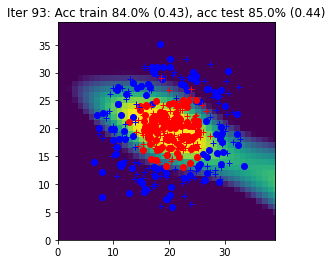

Iter 94: Acc train 84.5% (0.43), acc test 85.5% (0.43)


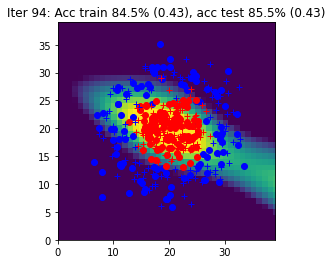

Iter 95: Acc train 84.5% (0.42), acc test 86.0% (0.43)


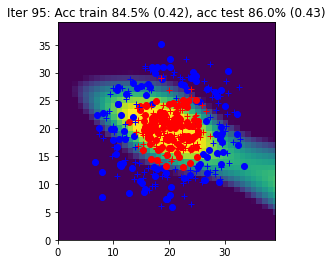

Iter 96: Acc train 85.0% (0.42), acc test 86.0% (0.42)


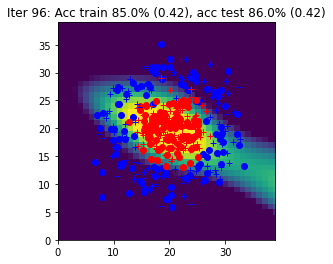

Iter 97: Acc train 84.5% (0.41), acc test 87.0% (0.42)


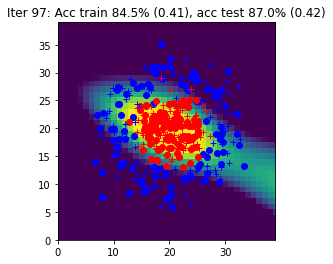

Iter 98: Acc train 85.0% (0.41), acc test 87.5% (0.41)


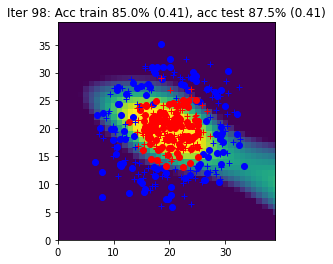

Iter 99: Acc train 85.0% (0.40), acc test 87.0% (0.41)


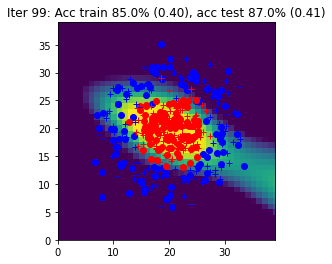

Iter 100: Acc train 84.5% (0.40), acc test 87.0% (0.41)


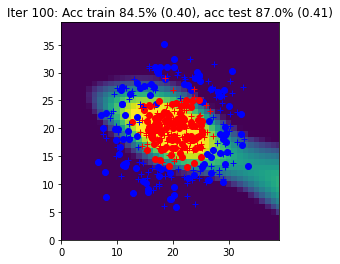

Iter 101: Acc train 85.0% (0.40), acc test 88.5% (0.40)


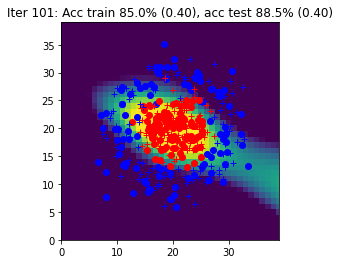

Iter 102: Acc train 85.5% (0.39), acc test 89.5% (0.40)


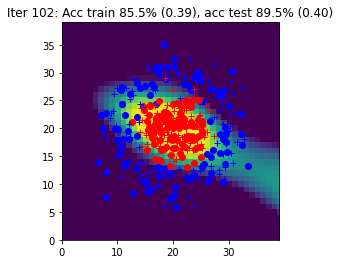

Iter 103: Acc train 86.0% (0.39), acc test 89.0% (0.39)


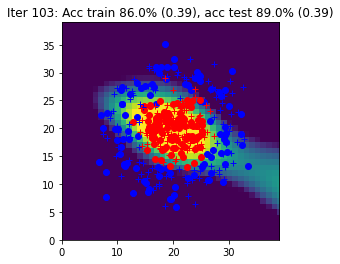

Iter 104: Acc train 85.5% (0.38), acc test 91.0% (0.39)


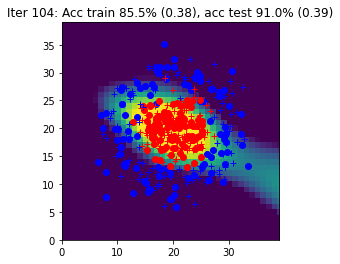

Iter 105: Acc train 88.0% (0.38), acc test 91.5% (0.38)


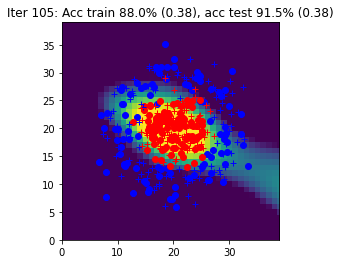

Iter 106: Acc train 88.5% (0.37), acc test 92.0% (0.38)


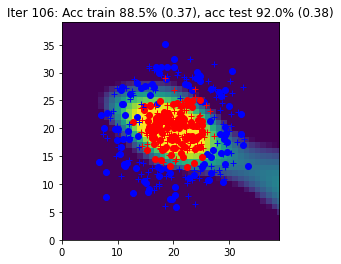

Iter 107: Acc train 88.5% (0.37), acc test 92.0% (0.37)


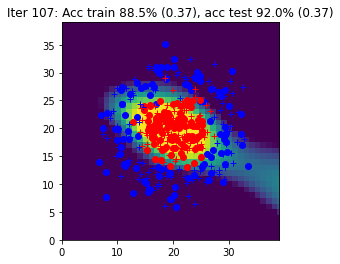

Iter 108: Acc train 88.0% (0.36), acc test 91.5% (0.37)


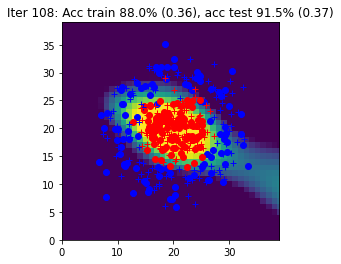

Iter 109: Acc train 89.0% (0.36), acc test 91.5% (0.37)


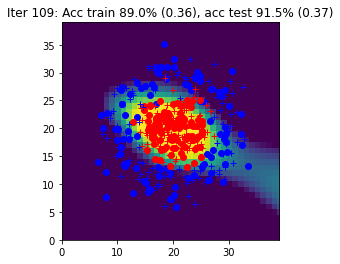

Iter 110: Acc train 89.0% (0.36), acc test 92.0% (0.36)


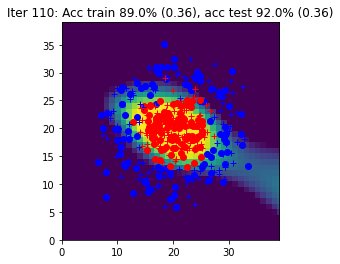

Iter 111: Acc train 89.5% (0.35), acc test 91.5% (0.36)


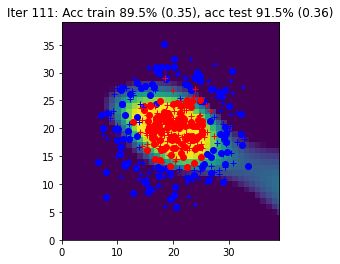

Iter 112: Acc train 89.5% (0.35), acc test 92.0% (0.35)


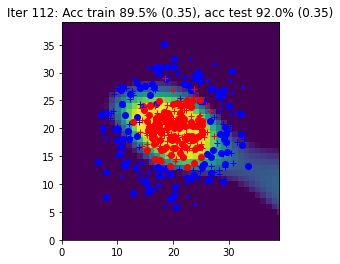

Iter 113: Acc train 90.5% (0.34), acc test 92.0% (0.35)


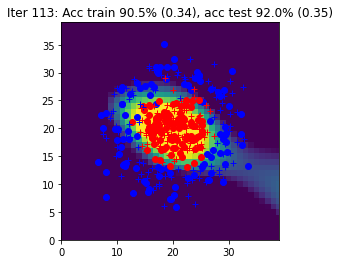

Iter 114: Acc train 91.0% (0.34), acc test 92.5% (0.34)


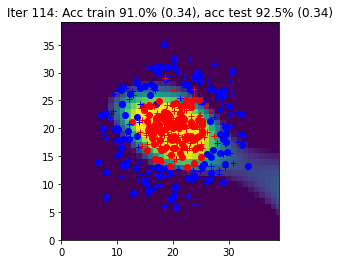

Iter 115: Acc train 91.5% (0.33), acc test 92.5% (0.34)


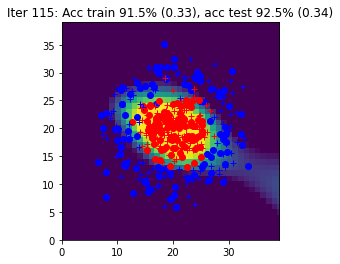

Iter 116: Acc train 91.5% (0.33), acc test 92.5% (0.33)


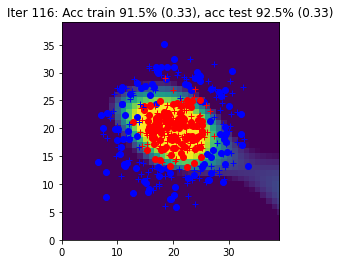

Iter 117: Acc train 92.0% (0.33), acc test 92.5% (0.33)


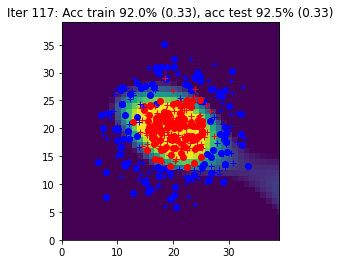

Iter 118: Acc train 92.0% (0.32), acc test 93.0% (0.33)


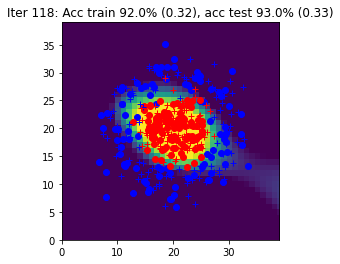

Iter 119: Acc train 92.0% (0.32), acc test 92.5% (0.32)


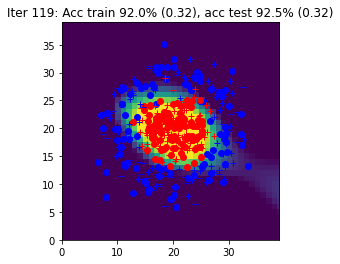

Iter 120: Acc train 92.5% (0.31), acc test 93.0% (0.32)


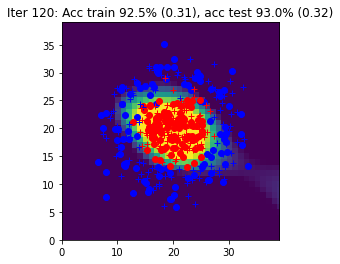

Iter 121: Acc train 92.5% (0.31), acc test 93.0% (0.31)


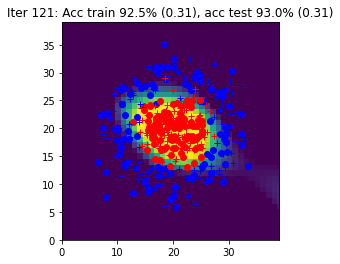

Iter 122: Acc train 92.5% (0.31), acc test 93.0% (0.31)


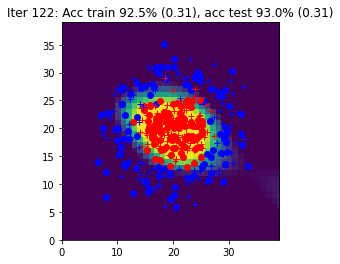

Iter 123: Acc train 93.5% (0.30), acc test 93.0% (0.31)


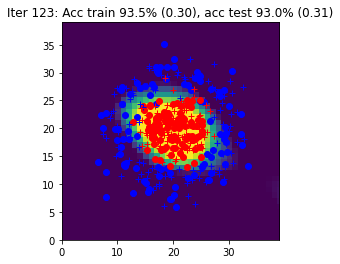

Iter 124: Acc train 94.0% (0.30), acc test 93.0% (0.30)


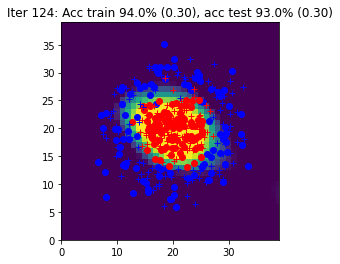

Iter 125: Acc train 94.5% (0.29), acc test 93.0% (0.30)


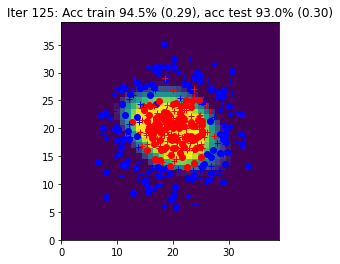

Iter 126: Acc train 94.5% (0.29), acc test 93.0% (0.30)


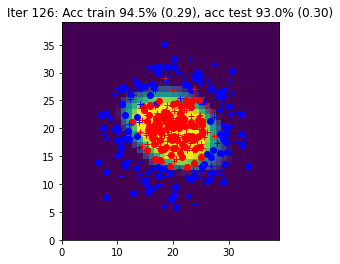

Iter 127: Acc train 94.5% (0.29), acc test 93.0% (0.29)


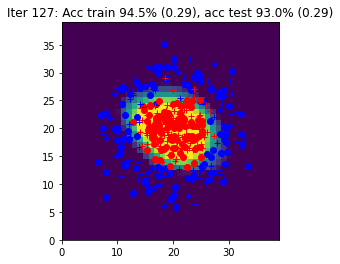

Iter 128: Acc train 95.5% (0.28), acc test 93.5% (0.29)


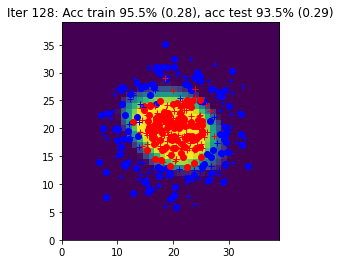

Iter 129: Acc train 95.5% (0.28), acc test 93.5% (0.29)


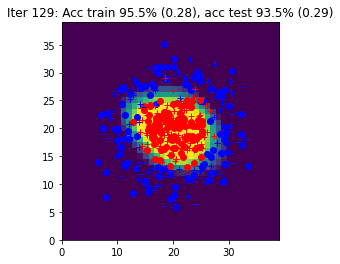

Iter 130: Acc train 96.0% (0.28), acc test 94.5% (0.28)


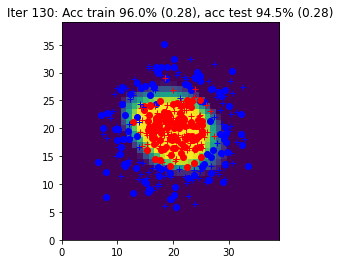

Iter 131: Acc train 96.0% (0.27), acc test 93.0% (0.28)


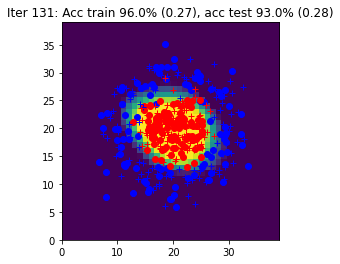

Iter 132: Acc train 94.5% (0.27), acc test 93.0% (0.28)


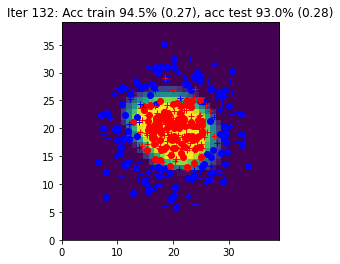

Iter 133: Acc train 96.0% (0.27), acc test 93.5% (0.27)


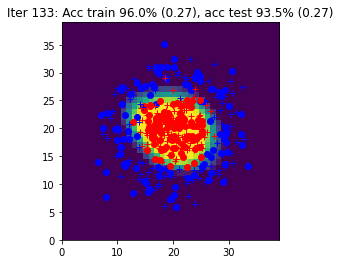

Iter 134: Acc train 96.0% (0.27), acc test 93.5% (0.27)


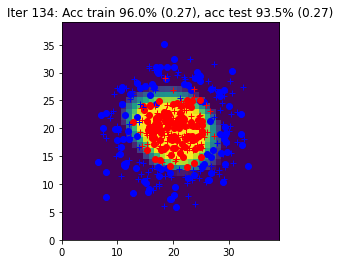

Iter 135: Acc train 96.0% (0.26), acc test 93.5% (0.27)


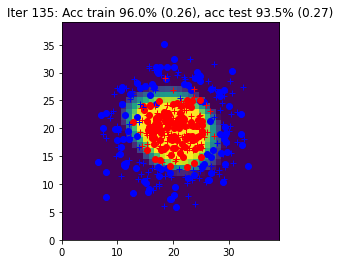

Iter 136: Acc train 96.0% (0.26), acc test 93.5% (0.26)


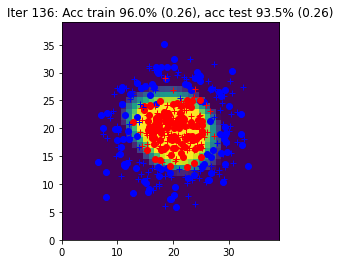

Iter 137: Acc train 96.5% (0.26), acc test 93.5% (0.26)


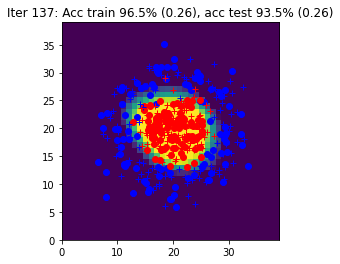

Iter 138: Acc train 96.0% (0.25), acc test 93.5% (0.26)


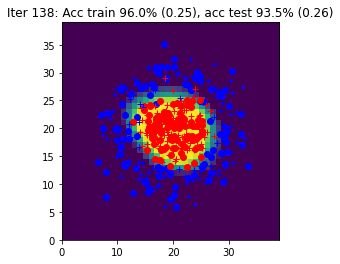

Iter 139: Acc train 96.5% (0.25), acc test 93.5% (0.26)


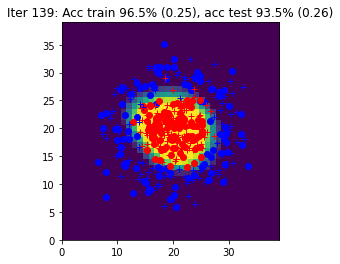

Iter 140: Acc train 96.5% (0.25), acc test 93.5% (0.25)


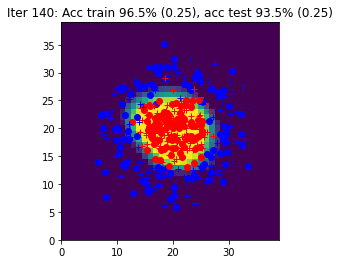

Iter 141: Acc train 96.5% (0.25), acc test 93.5% (0.25)


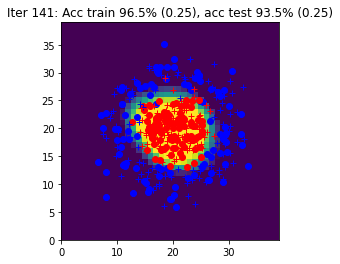

Iter 142: Acc train 97.0% (0.24), acc test 93.5% (0.25)


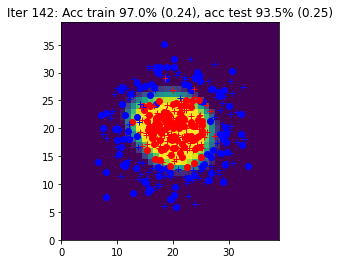

Iter 143: Acc train 97.0% (0.24), acc test 94.0% (0.25)


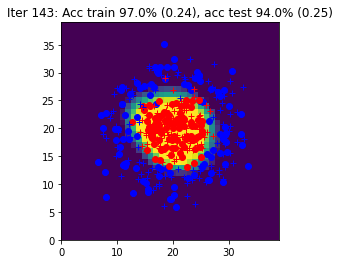

Iter 144: Acc train 97.0% (0.24), acc test 93.5% (0.24)


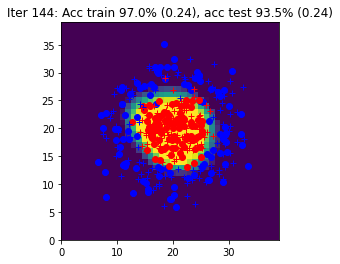

Iter 145: Acc train 97.0% (0.24), acc test 93.5% (0.24)


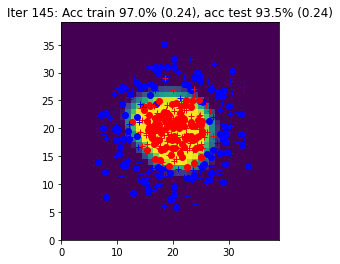

Iter 146: Acc train 97.0% (0.23), acc test 93.5% (0.24)


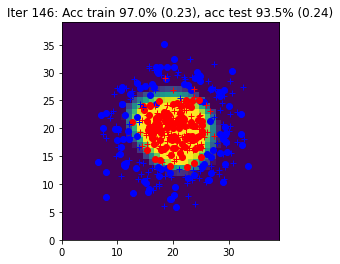

Iter 147: Acc train 97.0% (0.23), acc test 93.0% (0.24)


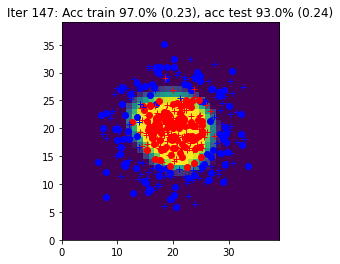

Iter 148: Acc train 97.0% (0.23), acc test 93.0% (0.24)


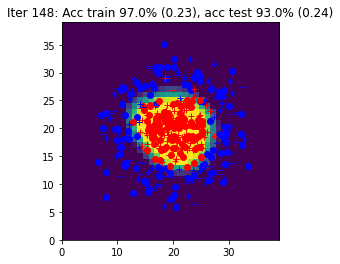

Iter 149: Acc train 97.0% (0.23), acc test 93.5% (0.24)


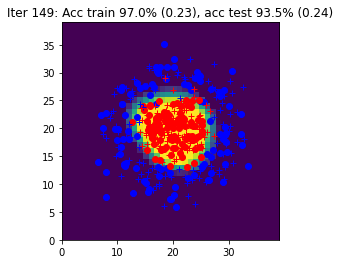

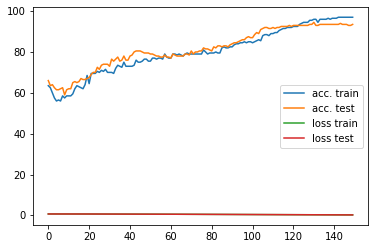

In [ ]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

model, loss, optim = init_model(nx, nh, ny, eta)

curves = [[],[], [], []]

# epoch
for iteration in range(150):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]
    Ytrain = torch.argmax(Ytrain, dim=1)

    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch]

        # écrire l'algorithme d'apprentissage sur le batch (X,Y)
        # en utilisant la fonction loss_accuracy
        # effectuer le forward en faisant un appel au modèle 
        # calculer les gradients avec la fonction backward de l'autograd 
        # Puis une "step" d'optimisation

        Yhat = model(X)
        L= loss(Yhat, Y)

        optim.zero_grad()
        L.backward()
        optim.step()
        


    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ytrain = torch.argmax(data.Ytrain, dim=1)
    Ytest = torch.argmax(data.Ytest, dim=1)
    Ltrain, acctrain = loss_accuracy(loss, Yhat_train, Ytrain)
    Ltest, acctest = loss_accuracy(loss, Yhat_test, Ytest)
    Ygrid = model(data.Xgrid)  

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    print(title) 
    data.plot_data_with_grid(torch.nn.Softmax(dim=1)(Ygrid.detach()), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()

# Partie 5 : MNIST

Reprendre le code d'entraînement précédent en l'appliquant au dataset MNIST.

In [ ]:
# init
data = MNISTData()
N = data.Xtrain.shape[0]
Nbatch = 100
nx = data.Xtrain.shape[1]
nh = 100
ny = data.Ytrain.shape[1]
eta = 0.03

model, loss, optim = init_model(nx, nh, ny, eta)


# epoch
for iteration in range(150):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]
    Ytrain = torch.argmax(Ytrain, dim=1)

    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch]

        # écrire l'algorithme d'apprentissage sur le batch (X,Y)
        # en utilisant la fonction loss_accuracy
        # effectuer le forward en faisant un appel au modèle 
        # calculer les gradients avec la fonction backward de l'autograd 
        # Puis une "step" d'optimisation

        Yhat = model(X)
        L= loss(Yhat, Y)

        optim.zero_grad()
        L.backward()
        optim.step()
        


    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ytrain = torch.argmax(data.Ytrain, dim=1)
    Ytest = torch.argmax(data.Ytest, dim=1)
    Ltrain, acctrain = loss_accuracy(loss, Yhat_train, Ytrain)
    Ltest, acctest = loss_accuracy(loss, Yhat_test, Ytest)
    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    print(title) 

Iter 0: Acc train 85.6% (0.52), acc test 87.0% (0.49)
Iter 1: Acc train 87.3% (0.46), acc test 87.6% (0.45)
Iter 2: Acc train 87.8% (0.41), acc test 88.2% (0.40)
Iter 3: Acc train 88.5% (0.39), acc test 89.2% (0.37)
Iter 4: Acc train 88.0% (0.40), acc test 88.2% (0.39)
Iter 5: Acc train 88.8% (0.38), acc test 88.8% (0.38)
Iter 6: Acc train 88.9% (0.38), acc test 89.3% (0.36)
Iter 7: Acc train 88.1% (0.39), acc test 88.4% (0.38)
Iter 8: Acc train 90.2% (0.33), acc test 90.1% (0.33)
Iter 9: Acc train 89.6% (0.35), acc test 89.2% (0.36)
Iter 10: Acc train 89.7% (0.36), acc test 89.7% (0.35)
Iter 11: Acc train 90.3% (0.33), acc test 90.7% (0.31)
Iter 12: Acc train 88.9% (0.36), acc test 89.4% (0.35)
Iter 13: Acc train 90.9% (0.30), acc test 90.9% (0.30)
Iter 14: Acc train 88.8% (0.36), acc test 88.9% (0.36)
Iter 15: Acc train 88.4% (0.38), acc test 88.4% (0.38)
Iter 16: Acc train 90.0% (0.33), acc test 90.2% (0.33)
Iter 17: Acc train 90.8% (0.31), acc test 90.8% (0.31)
Iter 18: Acc train 9

# Partie 6: Bonus: SVM


Entrainez un modèle SVM sur le jeu de data Circles.
Le code à remplir est indiqué par des commentaires.


Idées : 
- Essayer d'abord un SVM linéaire (sklearn.svm.LinearSVC dans scikit-learn). Est-ce que cela fonctionne bien ? Pourquoi
- Essayer d'autres kernels (possible avec sklearn.svm.SVC).
Lequel fonctionne le mieux ? Pourquoi ?
- Est-ce que le paramètre C de régularisation à un impact ? Pourquoi ?

In [ ]:
# data
data = CirclesData()
Xtrain = data.Xtrain.numpy()
Ytrain = data.Ytrain[:, 0].numpy()

Xgrid = data.Xgrid.numpy()

Xtest = data.Xtest.numpy()
Ytest = data.Ytest[:, 0].numpy()

def plot_svm_predictions(data, predictions):
      plt.figure(2)
      plt.clf()
      plt.imshow(np.reshape(predictions, (40,40)))
      plt.plot(data._Xtrain[data._Ytrain[:,0] == 1,0]*10+20, data._Xtrain[data._Ytrain[:,0] == 1,1]*10+20, 'bo', label="Train")
      plt.plot(data._Xtrain[data._Ytrain[:,1] == 1,0]*10+20, data._Xtrain[data._Ytrain[:,1] == 1,1]*10+20, 'ro')
      plt.plot(data._Xtest[data._Ytest[:,0] == 1,0]*10+20, data._Xtest[data._Ytest[:,0] == 1,1]*10+20, 'b+', label="Test")
      plt.plot(data._Xtest[data._Ytest[:,1] == 1,0]*10+20, data._Xtest[data._Ytest[:,1] == 1,1]*10+20, 'r+')
      plt.xlim(0,39)
      plt.ylim(0,39)
      plt.clim(0.3,0.7)
      plt.draw()
      plt.pause(1e-3)

In [ ]:
import sklearn.svm

############################
### Votre code ici   #######
### Entrainer le SVM #######
## Voir https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
## et https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
############################

svm = None

###########################

In [ ]:
## Affichage des résultats

Ytest_pred = svm.predict(Xtest)
accuracy = np.sum(Ytest == Ytest_pred) / len(Ytest)
print(f"Accuracy : {100 * accuracy:.2f}")
Ygrid_pred = svm.predict(Xgrid)
plot_svm_predictions(data, Ygrid_pred)